In [4]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

from utils import *
from scipy.stats import multivariate_normal as mvn

### Generate Data

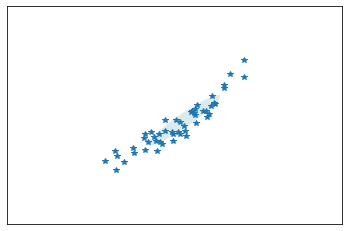

In [5]:
nb_data = 50
dim = 2
mu_true = np.array([14.,5.])
sigma_true = np.array([[5.,3.],[3.,2.]])
gauss = mvn(mean = mu_true, cov = sigma_true)
samples = gauss.rvs(nb_data)

#plot data & the underlying gaussian distribution
margin = [6,3]
bounds = [-margin[0] + np.min(samples[:,0]), margin[0] + np.max(samples[:,0]), -margin[1] + np.min(samples[:,1]),margin[1] + np.max(samples[:,1])]
ax = plt.subplot(111)
plot_gaussian_2D(mu_true,sigma_true,ax,color=[0.3,0.6,0.6],alpha=0.2)
plt.plot(samples[:,0], samples[:,1],'*')
plt.axis(bounds)
plt.tick_params(axis='x',    which='both',  bottom=False,  top=False, labelbottom=False) 
plt.tick_params(axis='y',    which='both',  left=False,  top=False, labelleft=False) 

### Estimate Gaussian from the data 

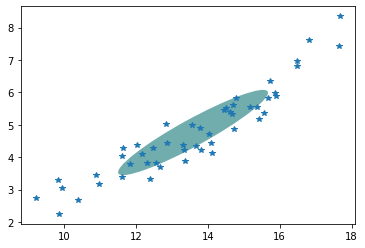

In [6]:
mu = np.mean(samples,axis=0)
sigma = np.cov(samples.T)
fig,ax = plt.subplots()
plot_gaussian_2D(mu,sigma,ax,color=[0.3,0.6,0.6],alpha=0.8)
plt.plot(samples[:,0], samples[:,1],'*')

#### Marginal Distribution 

In [7]:
index_in = np.array([0])
index_out = np.array([1])

In [8]:
mu_in = mu[index_in]
mu_out = mu[index_out]
sigma_in = sigma[index_in, index_in]
sigma_out = sigma[index_out, index_out]

#### Plot Marginal Distribution 

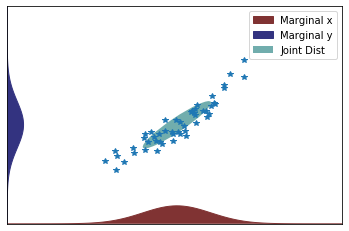

In [9]:
labels = ['Marginal x', 'Marginal y', 'Joint Dist', 'Cond Dist']
colors = [[0.5,0.2,0.2], [0.2,0.2,0.5], [0.3,0.6,0.6], [0.2, 0.7,0.2]]
fig,ax = plt.subplots()
plot_gaussian_1D(mu_in,np.sqrt(sigma_in),ax, offset = bounds[2], bound = bounds[0:2], label=labels[0], color = colors[0])
plot_gaussian_1D(mu_out,np.sqrt(sigma_out),ax,  offset = bounds[0], bound = bounds[2:],  label=labels[1], color = colors[1], orient='v')
plot_gaussian_2D(mu,sigma,ax,color=colors[2],alpha=0.8, label = labels[2])
plt.plot(samples[:,0], samples[:,1],'*')
plt.axis(bounds)
plt.legend()
plt.tick_params(axis='x',    which='both',  bottom=False,  top=False, labelbottom=False) 
plt.tick_params(axis='y',    which='both',  left=False,  top=False, labelleft=False) 

#### Conditioning 

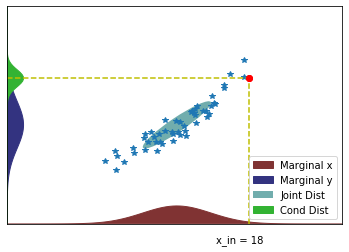

In [10]:
x_in = 18
mu_out_cond = mu_out + sigma[index_out, index_in]/sigma_in*(x_in-mu_in)
sigma_out_cond = sigma_out - sigma[index_out,index_in]/sigma_in*sigma[index_in,index_out]

fig,ax = plt.subplots()
plot_gaussian_1D(mu_in,np.sqrt(sigma_in),ax, offset = bounds[2], bound = bounds[0:2], label=labels[0], color = colors[0])
plot_gaussian_1D(mu_out,np.sqrt(sigma_out),ax,  offset = bounds[0], bound = bounds[2:],  label=labels[1], color = colors[1], orient='v')
plot_gaussian_2D(mu,sigma,ax,color=colors[2],alpha=0.8, label = labels[2])
plt.plot(samples[:,0], samples[:,1],'*')

#Plot the point of interest, and the conditional distribution
plt.plot(x_in, mu_out_cond, 'or')
plt.plot([x_in,x_in], [bounds[2],mu_out_cond], '--y')
plt.plot([bounds[0],x_in], [mu_out_cond,mu_out_cond], '--y')
plt.plot(x_in, mu_out_cond, 'or')

plot_gaussian_1D(mu_out_cond,np.sqrt(sigma_out_cond),ax,  offset = bounds[0], bound = bounds[2:], color=colors[3], label= labels[3] , orient='v')

plt.axis(bounds)
plt.legend(loc='lower right')
plt.text(x_in-2, bounds[2]-1, s='x_in = '+str(x_in))
plt.tick_params(axis='x',    which='both',  bottom=False,  top=False, labelbottom=False) 
plt.tick_params(axis='y',    which='both',  left=False,  top=False, labelleft=False) 

## Gaussian Product 

#### Define Gaussians 

[-6, 9, -6, 8]

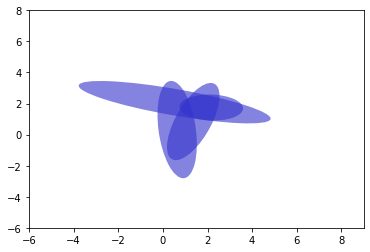

In [12]:
mus = []
sigmas = []
n_states = 4
n_var = 2
factor = 2
fig,ax = plt.subplots()
for i in range(n_states):
    mus.append(np.random.rand(2)*factor*2)
    d = np.random.normal(size=2)*factor
    sigmas.append(np.outer(d,d) + np.eye(n_var)*7e-1)
    plot_gaussian_2D(mus[-1],sigmas[-1],ax,alpha = 0.6,color = [0.2,0.2,0.8])

bounds = [-6,9,-6,8]
plt.axis(bounds)

#### Calculate the Gaussian Products 

#### Standard Computation 

In [13]:
Sigma_tmp = np.zeros((n_var, n_var))
Mu_tmp = np.zeros(n_var)

for i in range(n_states):
    Sigma_tmp += np.linalg.inv(sigmas[i])
    Mu_tmp += np.dot(np.linalg.inv(sigmas[i]), mus[i])

Sigma = np.linalg.inv(Sigma_tmp)
Mu = np.dot(Sigma,Mu_tmp)                 

#### Sequential Computation

In [14]:
#Initial iteration with the first two Gaussians
Sigma_tmp = np.zeros((n_var, n_var))
Mu_tmp = np.zeros(n_var)

for i in range(0,2):
    Sigma_tmp += np.linalg.inv(sigmas[i])
    Mu_tmp += np.dot(np.linalg.inv(sigmas[i]), mus[i])

Sigma_seq = np.linalg.inv(Sigma_tmp)
Mu_seq = np.dot(Sigma_seq,Mu_tmp)

#Subsequent iteration
for i in range(2,n_states):
    Sigma_tmp = np.linalg.inv(Sigma_seq)
    Mu_tmp = np.dot(Sigma_tmp, Mu_seq)

    Sigma_tmp += np.linalg.inv(sigmas[i])
    Mu_tmp += np.dot(np.linalg.inv(sigmas[i]), mus[i])
    
    Sigma_seq = np.linalg.inv(Sigma_tmp)
    Mu_seq = np.dot(Sigma_seq,Mu_tmp)

#### Plot the Product 

[-6, 9, -6, 8]

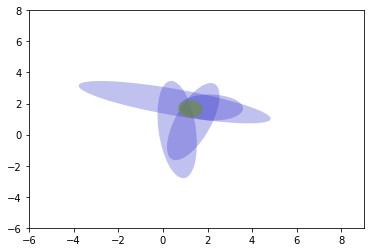

In [15]:
fig,ax = plt.subplots()
for i in range(n_states):
    plot_gaussian_2D(mus[i], sigmas[i],ax,color = [0.2,0.2,0.8],alpha = 0.3)
plot_gaussian_2D(Mu,Sigma,ax,color = [0.8,0.2,0.2], alpha = 0.4)
plot_gaussian_2D(Mu_seq,Sigma_seq,ax,color = [0.2,0.8,0.2], alpha = 0.4)
plt.axis(bounds)

## The law of Total Covariance

#### Generate n Gaussians 

In [16]:
n_var = 1 # the dimension of Gaussians
n_states = 3
mus = [0,1.5,3.5]
sigmas = [2, 1, .5]
priors = [.1, .6, .3]

bounds = [-5,8,0,0.3]    

[-5, 8, 0, 0.3]

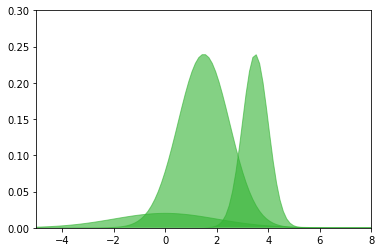

In [17]:
fig,ax = plt.subplots()
for i in range(n_states):
    plot_gaussian_1D(mus[i], sigmas[i], ax, bound = bounds[0:2], color = [0.2, 0.7, 0.2],alpha = 0.6, normalize = False, prior = priors[i])

plt.axis(bounds)

#### Estimate the mixture of Gaussians with one Gaussians

In [18]:
Mu = np.zeros(n_var)
Sigma = np.zeros((n_var, n_var))
for i in range(n_states):
    Mu += priors[i]*mus[i]
    Sigma += priors[i]*(sigmas[i] + np.outer(mus[i], mus[i]))
Sigma -= np.outer(Mu,Mu)

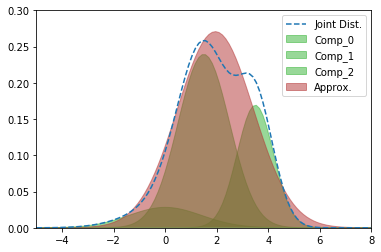

In [19]:
fig,ax = plt.subplots()
ys = []
for i in range(n_states):
    x,y = plot_gaussian_1D(mus[i], np.sqrt(sigmas[i]), ax, bound = bounds[0:2], color = [0.2, 0.7, 0.2], alpha = 0.5, prior = priors[i],  normalize = False, label = 'Comp_'+str(i))
    ys.append(y)
plot_gaussian_1D(Mu, np.sqrt(Sigma), ax, bound = bounds[0:2], color = [0.7, 0.2, 0.2], alpha = 0.5, prior = 1, normalize = False, label='Approx.')
y = np.sum(ys,axis=0)

plt.plot(x,y, '--', label='Joint Dist.')
plt.axis(bounds)
plt.legend(loc='upper right')